Thomas Dougherty

Probability and Statistics for Computer Science


### Analysis of the On-Time Performance (OTP) of New Jersey Transit Commuter Rail<br>
On-time performance refers to the level of success of a service adhering to its schedule. In this example I'll be exploring NJT commuter rail from March 2018 to March 2020. On-time performance data can be used for schedule planning, passenger information systems, and comparison to weather data. 
    

#### Data cleanup

In [1]:

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from helper_functions import *

#all_services = helper.combine_csvs("data\\services\\")
print("Reading CSV....")
all_services = pd.read_csv('data\\all_services.csv')
all_services = helper.format_services(all_services)
all_services.head(10)

Reading CSV....
Dropping columns...
Changing datatypes...
Done formatting dataframe


,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105.0,New York Penn Station,105.0,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105.0,Secaucus Upper Lvl,38187.0,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133301,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187.0,Newark Penn Station,107.0,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116638,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107.0,Newark Airport,37953.0,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166626,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953.0,North Elizabeth,109.0,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166626,Northeast Corrdr,NJ Transit
5,2018-03-01,3805,6.0,North Elizabeth,109.0,Elizabeth,41.0,2018-03-02 01:52:00,2018-03-02 01:52:01,0.016663,Northeast Corrdr,NJ Transit
6,2018-03-01,3805,7.0,Elizabeth,41.0,Linden,70.0,2018-03-02 01:58:00,2018-03-02 01:58:05,0.083313,Northeast Corrdr,NJ Transit
7,2018-03-01,3805,8.0,Linden,70.0,Rahway,127.0,2018-03-02 02:02:00,2018-03-02 02:01:03,0.000000,Northeast Corrdr,NJ Transit
8,2018-03-01,3805,9.0,Rahway,127.0,Metropark,83.0,2018-03-02 02:08:00,2018-03-02 02:08:00,0.000000,Northeast Corrdr,NJ Transit
9,2018-03-01,3805,10.0,Metropark,83.0,Metuchen,84.0,2018-03-02 02:13:00,2018-03-02 02:13:10,0.166626,Northeast Corrdr,NJ Transit


## Visualization of On Time Performance
New Jersey Transit defines "On Time" as a variation of service within 6 minutes of the published schedule. A function iterates through the data frame and classifies each arrival into one of four categories by keeping a count in a size 4 array. 

#### All Services by Year

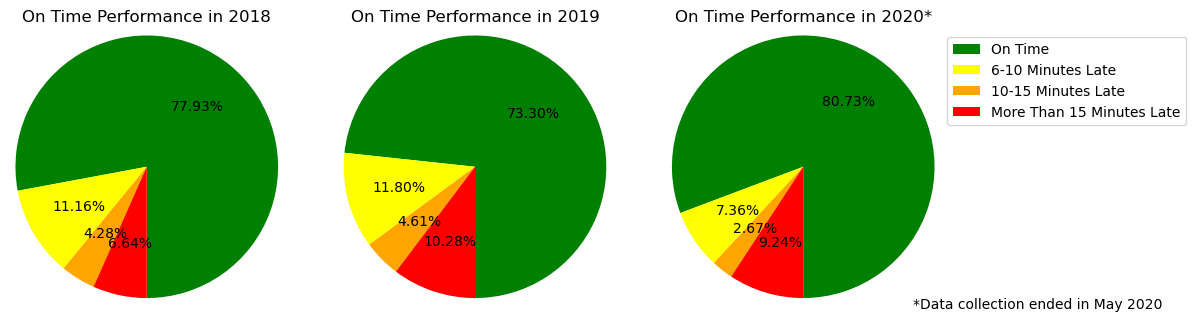

In [2]:
#To Do: automate this
# Get the data for each subplot
data_2018 = helper.categorize_lateness(all_services[(all_services['date'].dt.year == 2018)])
data_2019 = helper.categorize_lateness(all_services[(all_services['date'].dt.year == 2019)])
data_2020 = helper.categorize_lateness(all_services[(all_services['date'].dt.year == 2020)])
late_labels = ['On Time', '6-10 Minutes Late', '10-15 Minutes Late', 'More Than 15 Minutes Late']
late_colors = ['green', 'yellow', 'orange', 'red']

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

ax1.pie(data_2018, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax1.title.set_text('On Time Performance in 2018')
ax2.pie(data_2019, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax2.title.set_text('On Time Performance in 2019')
ax3.pie(data_2020, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax3.title.set_text('On Time Performance in 2020*')
plt.text(1.0, -1.3, "*Data collection ended in May 2020", fontsize=10)
fig.set_figwidth(12)
plt.legend(bbox_to_anchor = (1.0, 1.0), labels = late_labels)
plt.show()

#### All Services by Season

Using the date column, arrivals will be divided into four primary categories. The arrivals will be sub-categorized by how many minutes late then plotted onto a pie chart to show on time performance in the seasons of the year

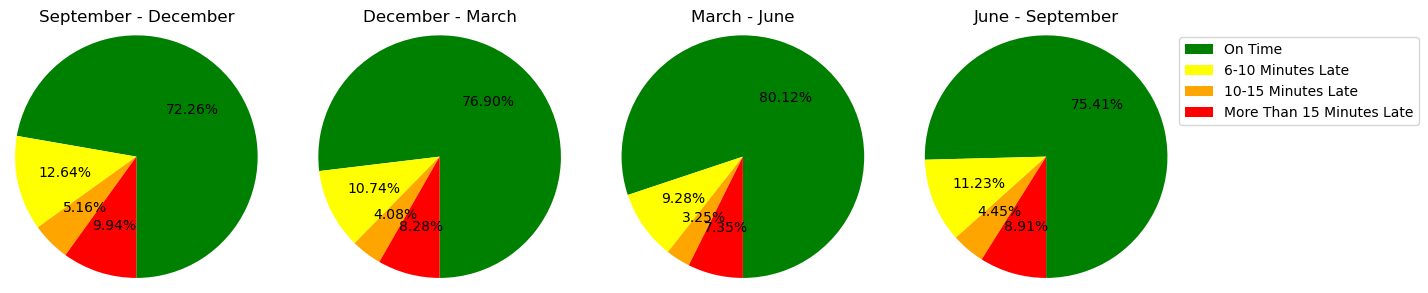

In [3]:
# TO DO: Automate this
data_fall = helper.categorize_lateness(all_services[(all_services['date'].dt.month >= 9) & (all_services['date'].dt.month <= 12)])
# could not get a 'true' boolean value for the winter months and had to broken up into two separate dfs
df1 = all_services[(all_services['date'].dt.month <= 3)]
df2 = all_services[(all_services['date'].dt.month >= 12)]
result = pd.concat([df1,df2])
data_winter = helper.categorize_lateness(result) 
data_spring = helper.categorize_lateness(all_services[(all_services['date'].dt.month >= 3) & (all_services['date'].dt.month <=6)])
data_summer = helper.categorize_lateness(all_services[(all_services['date'].dt.month >= 6) & (all_services['date'].dt.month <=9)])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

# and this
ax1.pie(data_fall, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax1.title.set_text('September - December')
ax2.pie(data_winter, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax2.title.set_text('December - March')
ax3.pie(data_spring, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax3.title.set_text('March - June')
ax4.pie(data_summer, colors=late_colors, radius = 1.2, autopct = "%0.2f%%", startangle=270)
ax4.title.set_text('June - September')

fig.set_figwidth(15)
fig.set_figheight(5)

plt.legend(bbox_to_anchor = (1.0, 1.0), labels = late_labels)
plt.show()

In Autumn, tree leaves tend to fall on the rails. As they're crushed by the weight of the trains, the wheels of the train and the rails they ride on become coated in a low-friction residue. he buildup is incremental with each passing train. So unlike snow, the buildup cannot be prevented by the regular running of trains. These condition makes it difficult for trains to accelerate, decelerate, and maintain safe speeds leading to delays and other service disruptions so we can expect a lower On Time Performance during the autumn months. 

##### OTP by Line <br>


In [4]:
njt_lines = all_services['line'].unique()

line_labels = ['Northeast Corridor', 'North Jersey Coast', 'Main Line', 'Morristown Line', 'Gladstone Branch',
               'Raritan Valley', 'Bergen County Line', 'Atlantic City Line', 'Montclair-Boonton',
               'Princeton Shuttle', 'Pascack Valley']

#otp_by_line_2018 = helper.get_otp_data(all_services,'line', njt_lines, 2018)
#otp_by_line_2019 = helper.get_otp_data(all_services,'line', njt_lines, 2019)
#helper.chart_subplots(otp_by_line_2018,line_labels, late_labels, late_colors, "On Time Performance In 2018")
#helper.chart_subplots(otp_by_line_2019,line_labels, late_labels, late_colors, "On Time Performance In 2019")


## Reporting to Final Destination On Time <br>
#### New York Penn Station <br>
New York Penn is the busiest transportation facility in the Western Hemisphere, so naturally it is major terminus for New Jersey Transit. Below is a comparison of the on time performance for services to New York Penn Station for different time intervals. The lower limit of the bar chart is set to 65 show the difference in OTP better.

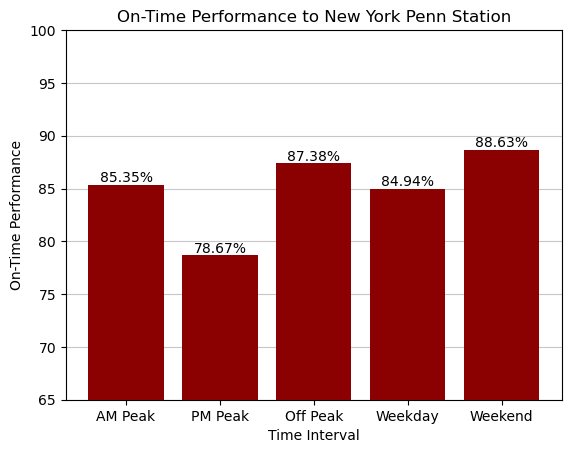

In [29]:
trains_to_nyp = all_services[(all_services['to'] == 'New York Penn Station')]
#trains_from_nyp = all_services[(all_services['from'] == 'New York Penn Station')]
am_start = pd.to_datetime("06:00:00")
am_end = pd.to_datetime("09:30:00")
pm_start = pd.to_datetime("16:00:00")
pm_end = pd.to_datetime("19:00:00")
# AM Peak
am_peak_nyp = trains_to_nyp[(trains_to_nyp['scheduled_time'].dt.time >= am_start.time()) & (trains_to_nyp['scheduled_time'].dt.time <= am_end.time())]
am_peak_nyp = am_peak_nyp.drop(am_peak_nyp[am_peak_nyp['date'].dt.weekday > 4].index)
# PM Peak
pm_peak_nyp = trains_to_nyp[(trains_to_nyp['scheduled_time'].dt.time >= pm_start.time()) & (trains_to_nyp['scheduled_time'].dt.time <= pm_end.time())]
pm_peak_nyp = pm_peak_nyp.drop(pm_peak_nyp[pm_peak_nyp['date'].dt.weekday > 4].index)

#Off Peak
off_peak1 = trains_to_nyp[(trains_to_nyp['scheduled_time'].dt.time < am_start.time())]
off_peak2 = trains_to_nyp[(trains_to_nyp['scheduled_time'].dt.time > am_end.time()) & (trains_to_nyp['scheduled_time'].dt.time < pm_start.time())]
off_peak3 = trains_to_nyp[(trains_to_nyp['scheduled_time'].dt.time > pm_end.time())]
off_peak_nyp = pd.concat([off_peak1, off_peak2])
off_peak_nyp = pd.concat([off_peak3, off_peak_nyp])
off_peak_nyp = off_peak_nyp.drop(off_peak_nyp[off_peak_nyp['date'].dt.weekday > 4].index)

#all weekday
weekday_nyp = trains_to_nyp[(trains_to_nyp['scheduled_time'].dt.weekday <= 4)]
#all weekend
weekend_nyp = trains_to_nyp[(trains_to_nyp['scheduled_time'].dt.weekday > 4)]

lines_to_nyp = trains_to_nyp['line'].unique()
categories = ['AM Peak', 'PM Peak', 'Off Peak', 'Weekday', 'Weekend']

am_peak_otp = helper.on_time_performance(am_peak_nyp)
pm_peak_otp = helper.on_time_performance(pm_peak_nyp)
off_peak_otp = helper.on_time_performance(off_peak_nyp)
weekday_otp = helper.on_time_performance(weekday_nyp)
weekend_otp = helper.on_time_performance(weekend_nyp)



otps = [am_peak_otp, pm_peak_otp, off_peak_otp, weekday_otp, weekend_otp]
fig, ax = plt.subplots()
ax.grid(axis='y', linestyle='solid', alpha=0.7, zorder=0)
xpos = [1, 2, 3, 4, 5]
bars = ax.bar(xpos, otps, color='darkred',zorder=3)
ax.set_title('On-Time Performance to New York Penn Station')
ax.set_xlabel('Time Interval')
ax.set_ylabel('On-Time Performance')
ax.set_ylim(65,100)
ax.set_xticks(xpos)
ax.set_xticklabels(categories)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{otps[i]:.2f}%", ha='center', va='bottom', color='black')

plt.show()
